<a href="https://colab.research.google.com/github/matheus-de-araujo/fakenews-classifier-notebook/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importação das bibliotecas

In [13]:
import pandas as pd
import numpy as np
import os, re
import hashlib
import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import itertools
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle

# 2. Realizando a leitura do dataset

In [14]:
if os.path.exists('dataset-fake-br-for-tcc/'):
    print('A pasta já existe!')
else:
  !git clone https://github.com/matheus-de-araujo/dataset-fake-br-for-tcc.git

def returnDataSetFrame():
    dataFrame = pd.DataFrame(columns=[ 'text', 'raw', 'label'])
    paths = ['dataset-fake-br-for-tcc/full_texts/fake/', 'dataset-fake-br-for-tcc/full_texts/true/']

    for filename in os.listdir(paths[0]):
        with open(paths[0]+filename, 'r') as f:
            text = f.read()
            dataFrame.loc[len(dataFrame)] = [preProcessing(text), text, 'fake']

    for filename in os.listdir(paths[1]):
        with open(paths[1]+filename, 'r') as f:
            text = f.read()
            dataFrame.loc[len(dataFrame)] = [preProcessing(text), text, 'true']
    return dataFrame

A pasta já existe!


# 3. Funções para limpeza dos dados e remoção dos StopWords

In [15]:
nltk.download('stopwords')
nltk.download('rslp')

def cleaning_text(text):
    text = text.lower()
    text = re.sub("(\\d|\\W|\d+\w+|\\n)+"," ",text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def removeStopWords(text):
    stopwords_nltk = nltk.corpus.stopwords.words('portuguese')
    text = ' '.join([word for word in text.split() if word not in stopwords_nltk])
    return text

def preProcessing(text):
    return removeStopWords(cleaning_text(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# 4. Obténdo o dataset e guardando em data

In [28]:
data_text = returnDataSetFrame()
data_text.head()

,text,raw,label
0,rede social suspende conta rapper americana xe...,Rede social suspende conta de rapper americana...,fake
1,coreia norte divulga vídeo trump cemitério sug...,Coreia do Norte divulga vídeo com Trump no cem...,fake
2,grave tentativa ajudar dilma raul castro convo...,"Isso é grave! Na tentativa de ajudar Dilma, R...",fake
3,cientistas adiantam relógio apocalipse alegam ...,"Cientistas adiantam o ""Relógio do Apocalipse"" ...",fake
4,impeachment janaína paschoal destrói conversa ...,#Impeachment  Janaína Paschoal DESTRÓI conver...,fake


# 5. Funções para plotar nuvem de palavras

In [17]:
def bagOfWords(text):
    words = text.split()
    counter = Counter(words) 
    return counter.most_common()
    
def cloudOfWords(text, n = 50,title='Bag of Words'):
    word_freq = dict((x, y) for x, y in bagOfWords(text)[:n])
    wordcloud = WordCloud(background_color="white", width=800, height=400)
    wordcloud.generate_from_frequencies(word_freq)
    plt.figure()
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

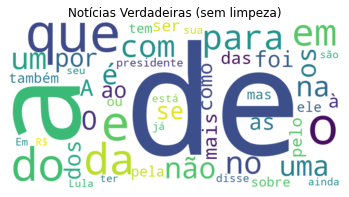

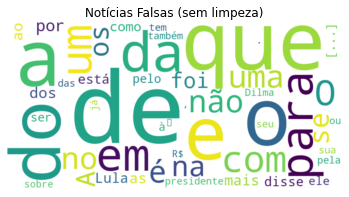

In [18]:
data_true = data_text[data_text.label == 'true'].text.values
data_fake = data_text[data_text.label == 'fake'].text.values

data_raw_true_no_cleaning = ' '.join(data_text[data_text.label == 'true']['raw'])
data_raw_fake_no_cleaning = ' '.join(data_text[data_text.label == 'fake']['raw'])

data_raw_true_cleaning = ' '.join(data_text[data_text.label == 'true']['text'])
data_raw_fake_cleaning = ' '.join(data_text[data_text.label == 'fake']['text'])


cloudOfWords(text=data_raw_true_no_cleaning, title='Notícias Verdadeiras (sem limpeza)')
cloudOfWords(text=data_raw_fake_no_cleaning, title='Notícias Falsas (sem limpeza)')

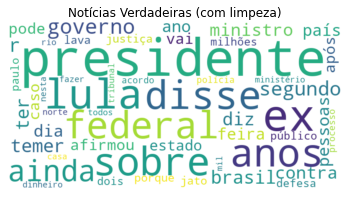

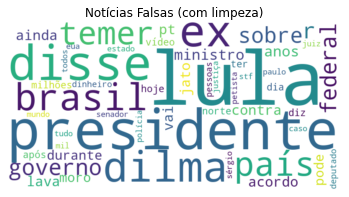

In [19]:
cloudOfWords(text=cleaning_text(removeStopWords(data_raw_true_cleaning)), title='Notícias Verdadeiras (com limpeza)')
cloudOfWords(text=cleaning_text(removeStopWords(data_raw_fake_cleaning)), title='Notícias Falsas (com limpeza)')

## 7. Plotando o gráfico que demonstra número de ocorrência

Número total de palavras: 2614766


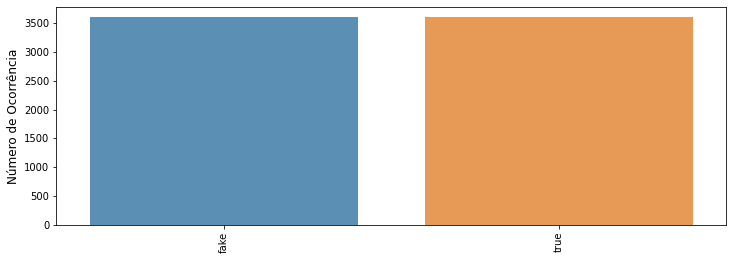

In [20]:
print("Número total de palavras: " + str(data_text['text'].apply(lambda x: len(x.split(' '))).sum()))

label_plot = data_text['label'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(y=label_plot.values, x=label_plot.index, alpha=0.8)
plt.ylabel('Número de Ocorrência', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [21]:
vectorizer = TfidfVectorizer(max_df=0.85)

data = data_text.sample(frac=1)
text = data['text']
label = data['label'].rank(method='dense', ascending=False).astype(int)

data_train = vectorizer.fit_transform(text)

x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.33, random_state=42)

x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.fit_transform(x_test)

In [22]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

---- Scores ----
[0.9689441  0.94824017 0.95652174 0.96066253 0.95850622 0.93568465
 0.95435685 0.97717842 0.96887967 0.95643154]
              precision    recall  f1-score   support

           1       0.95      0.95      0.95      1176
           2       0.95      0.95      0.95      1200

    accuracy                           0.95      2376
   macro avg       0.95      0.95      0.95      2376
weighted avg       0.95      0.95      0.95      2376



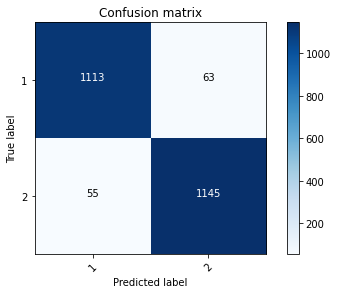

In [23]:
neural_classifier = MLPClassifier(hidden_layer_sizes=(5,12),activation='tanh',solver='lbfgs',random_state=1)
scores_neural = cross_val_score(neural_classifier, x_train, y_train, cv=10)
Y_pred = cross_val_predict(neural_classifier,x_test,y_test, cv=10)
conf_mat = confusion_matrix(y_test,Y_pred)
print("---- Scores ----")
print(scores_neural)
print(classification_report(y_test, Y_pred))
plot_confusion_matrix(conf_mat, classes=[1, 2],title='Confusion matrix')

In [24]:
pickle.dump(vectorizer,open('model.pkl','wb'))